# EDA of UCSD DSC 20 Grades (Spring 2018)
DSC 20 (Programming and Data Structures) is an awesome data science course taught at UC San Diego. The course is taught using Python and a good portion of the course is spent building off of the concepts in its prerequisite course, DSC 10 (Principles of Data Science). This includes the use of the pandas library for big data processing.

At the end of the course, grade breakdowns were released via CSV files (quite suitably). We were given a dataset. So of course, I'm going to analyze it.

We'll be analyzing student grades for the quarter I took this course, Spring Quarter 2018.

## Course Grade Breakdown
Below is the grade breakdown used for the calculation of the final grade given at the end of the course. Taken from the [course syllabus](https://sites.google.com/a/eng.ucsd.edu/dsc20-spring-2018/):

>- 30% Final Exam
- 25% Homework Assignments
- 15% Midterm Exam
- 15% Labs
- 10% Final Project
- 5% Class Participation
>
>You must score at least 55% on the final exam to pass the course.  If you score lower than 55% on the final, you will receive an F in the course, regardless of your overall average.

In [1]:
final_exam_cutoff = .55

## Packages and Utilities
We'll first import packages and define additional utilties to be used for our analysis.

In [2]:
from itertools import combinations  # Combinations (combinatorics)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from matplotlib.lines import Line2D
from natsort import natsorted  # Natural sorting
import numpy as np

import pandas as pd
pd.set_option('display.precision', 4)
pd.set_option('max_columns', 30)
pd.set_option('max_colwidth', 100)
pd.set_option('max_rows', 10)

import re  # Regular expressions
import scipy.stats as stats
import seaborn as sns

In [3]:
%%javascript
/* Disable auto-scrolling of long cell output */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Import and Processing
We'll take a look at the raw dataset, then process our dataset into the most convenient format for our analysis.

If you were wondering, my secret code is gko011

### Raw Dataset

In [4]:
pd.read_csv('Grades.csv').head()

,Secrete Code,ants_bees_score,hw1_score,hw10_score,hw2_score,hw3_score,hw4_score,hw5_score,hw6_score,hw7_score,hw8_score,hw9_score,lab01_score,lab02_score,lab03_score,lab04_score,lab05_score,lab07_score,lab08_score,lab09_score,lab10_score,lab6_score,Midterm,Final,Participation,LAB_Total,HW_Total,Weighted_Total
0,vkk236,1.08,0.78,0.8,0.86,0.90,0.96,0.86,1.00,1.00,0.800,0.88,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.0,1.0000,1.0,0.9250,1.0444,0.8889,1.0000,0.9075,0.9814
1,blcrqj,1.08,0.94,0.6,0.93,0.88,0.99,0.93,0.90,0.87,0.930,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.8375,0.9667,1.0000,1.0000,0.9312,0.9564
2,bxc522,1.08,0.97,0.0,0.84,0.91,0.99,0.93,1.00,0.92,0.990,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.9125,0.9422,1.0000,1.0000,0.9588,0.9672
3,sghvkpdq,1.00,0.99,1.0,0.68,0.86,0.84,0.88,0.96,0.96,0.410,0.83,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8571,1.0,0.9250,0.7889,0.6667,0.9841,0.9150,0.8851
4,djhpdzdw,1.08,0.88,0.0,0.95,0.95,0.96,0.97,0.99,1.00,0.896,0.80,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,0.8625,0.8733,1.0000,1.0000,0.9495,0.9367


In [5]:
# Import and sort by Total
df = pd.read_csv('Grades.csv').sort_values('Weighted_Total', ascending=False).reset_index(drop=True)
df.index += 1

# Add tuples of HW and Lab scores
hw_cols = natsorted(filter(re.compile('hw\d+_score').match, df.columns))
lab_cols = natsorted(filter(re.compile('lab\d+_score').match, df.columns))
df['HW'] = df[hw_cols].apply(lambda row: tuple(row), axis=1)
df['Lab'] = df[lab_cols].apply(lambda row: tuple(row), axis=1)

# Select and rename columns
df = df[['Secrete Code','Weighted_Total','Final','Midterm','HW_Total','LAB_Total','ants_bees_score','Participation','HW','Lab']]
df.rename({'Secrete Code':'ID','Weighted_Total':'Total', 'HW_Total':'HW_Avg', 'LAB_Total':'Lab_Avg', 'ants_bees_score':'Project'}, axis=1, inplace=True)

# Remove students who dropped
df = df.iloc[:df.shape[0] - tuple(df['Final'] > 0)[::-1].index(True)]
n = df.shape[0]

## EDA

In [6]:
df.head(3)

,ID,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation,HW,Lab
1,vkb218,1.0229,1.0778,0.9750,0.9813,1.0,1.08,1.0,"(1.0, 0.65, 0.98, 0.99, 0.93, 0.96, 0.98, 0.96, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
2,gko011,1.0225,1.0889,0.9375,0.9888,1.0,1.08,1.0,"(1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"
3,zhc195,1.0097,1.1222,0.9375,0.9295,1.0,1.00,1.0,"(0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)"


In [7]:
df.describe()

,Total,Final,Midterm,HW_Avg,Lab_Avg,Project,Participation
count,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000,123.0000
mean,0.8523,0.7751,0.7660,0.8588,0.9786,1.0091,0.8485
std,0.0994,0.1983,0.1647,0.1109,0.0475,0.1365,0.2497
min,0.5687,0.0000,0.0000,0.4006,0.7000,0.3000,0.0000
25%,0.7954,0.6633,0.6750,0.8062,0.9841,1.0000,0.7963
50%,0.8604,0.7889,0.8000,0.8975,1.0000,1.0800,0.9630
75%,0.9333,0.9183,0.8875,0.9350,1.0000,1.0800,1.0000
max,1.0229,1.1222,0.9750,0.9925,1.0000,1.0800,1.0000


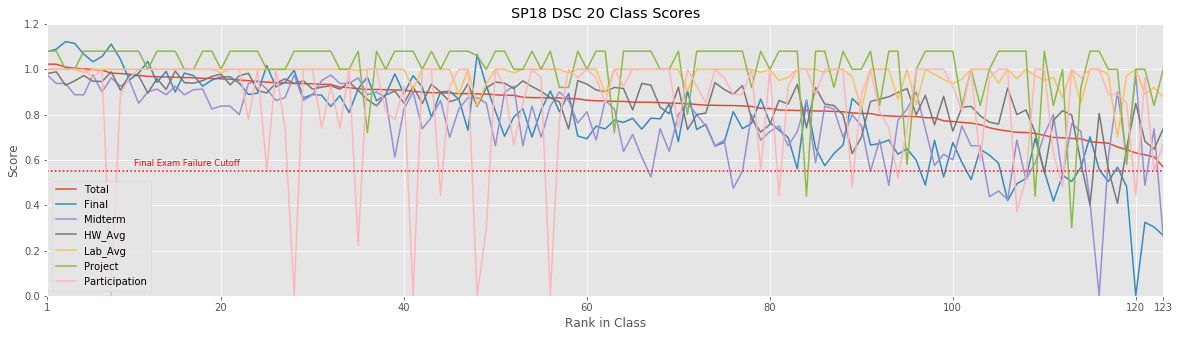

In [8]:
df.plot(figsize=(20,5))
plt.title('SP18 DSC 20 Class Scores')
plt.xlabel('Rank in Class')
plt.ylabel('Score')
plt.axhline(final_exam_cutoff, c='r', ls=':', lw=1.5)
plt.text(10.5, .575, 'Final Exam Failure Cutoff', color='r', size='small')
plt.axis([1,n,0,1.2])
plt.xticks(list(range(20,n,20)) + [1,n]);

In [9]:
# confidentiality

In [ ]:
criteria = 'Total', 'Final', 'Midterm', 'HW_Avg', 'Lab_Avg', 'Project', 'Participation'
nrows = len(criteria)

plt.figure(figsize=(12,1.5*nrows))

for i, criterion in enumerate(criteria, 1):
    data = df[criterion]
    mean, sd = np.mean(data), np.std(data)
    
    # Histogram
    plt.subplot(nrows/2, 4, 2*i-1)
    data.hist(density=True)
    x = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    plt.plot(x, stats.gaussian_kde(data)(x), label='Kernel Density Estimation')
    plt.plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal Distribution')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(0, 1.2)
    plt.legend(loc='upper left')

    # Q-Q Plot
    plt.subplot(nrows/2, 4, 2*i)
    stats.probplot(data, plot=plt)
    plt.title('Normal Q-Q Plot')
    plt.xlabel('Theoretical Quantiles of Normal Distribution')
    plt.ylabel('Sample Quantiles of {} Scores'.format(criterion))
    
plt.tight_layout()
#make font smaller

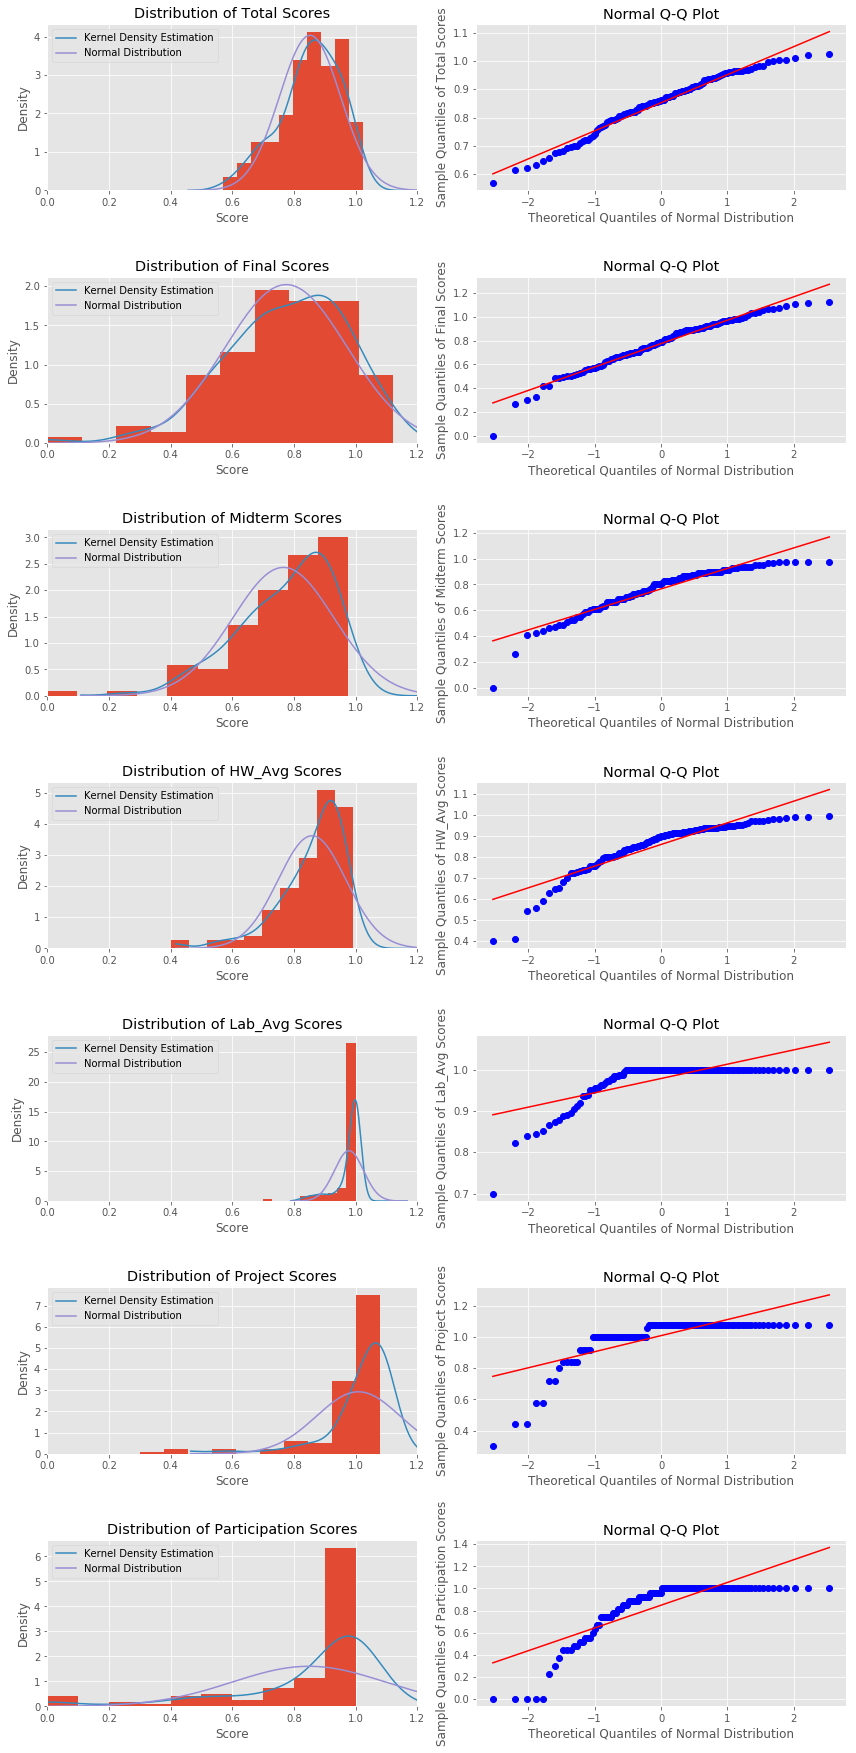

In [54]:
criteria = 'Total', 'Final', 'Midterm', 'HW_Avg', 'Lab_Avg', 'Project', 'Participation'
nrows = len(criteria)

plt.figure(figsize=(12,3.5*nrows))

for i, criterion in enumerate(criteria, 1):
    data = df[criterion]
    mean, sd = np.mean(data), np.std(data)
    
    # Histogram
    plt.subplot(nrows, 2, 2*i-1)
    data.hist(density=True)
    x = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    plt.plot(x, stats.gaussian_kde(data)(x), label='Kernel Density Estimation')
    plt.plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal Distribution')
    plt.title('Distribution of {} Scores'.format(criterion))
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(0, 1.2)
    plt.legend(loc='upper left')

    # Q-Q Plot
    plt.subplot(nrows, 2, 2*i)
    stats.probplot(data, plot=plt)
    plt.title('Normal Q-Q Plot')
    plt.xlabel('Theoretical Quantiles of Normal Distribution')
    plt.ylabel('Sample Quantiles of {} Scores'.format(criterion))
    
plt.tight_layout()

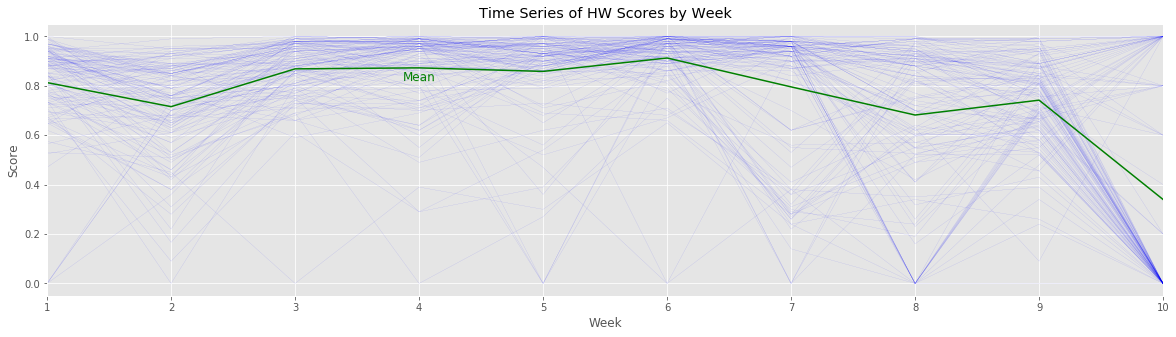

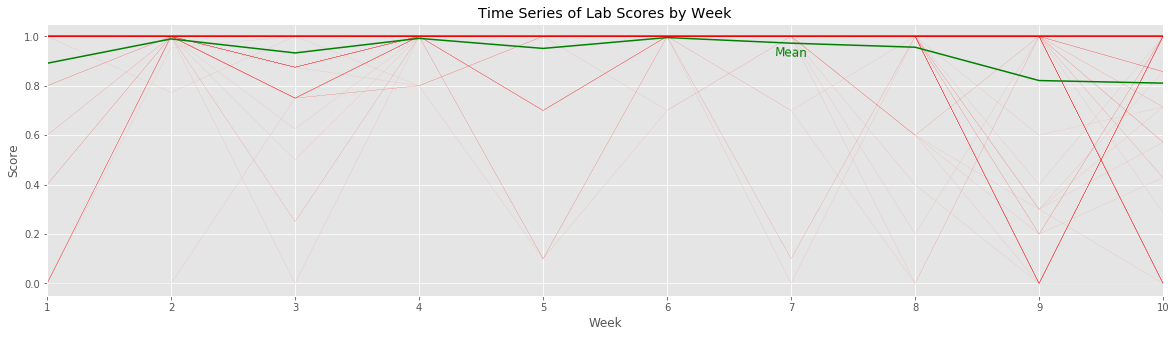

In [11]:
hw_averages, lab_averages = tuple(map(np.mean, zip(*df['HW']))), tuple(map(np.mean, zip(*df['Lab'])))
weeks = range(1,11)

hw = 'HW', 'b', hw_averages
lab = 'Lab', 'r', lab_averages
texts = []

for assignment, color, averages in hw, lab:
    plt.figure(figsize=(20,5))
    
    # All scores
    for row in range(n):
        plt.plot(weeks, df.iloc[row][assignment], color, lw=.05)
        
    # Averages (and associated labels)
    plt.plot(weeks, averages, 'g')
    texts.append(plt.text(0, 0, 'Mean', color='g', size='large'))
    
    plt.title('Time Series of {} Scores by Week'.format(assignment))
    plt.xlabel('Week')
    plt.ylabel('Score')
    plt.axis([1,10,-.05,1.05])
    plt.xticks(range(1,11))
        
plt.setp(texts[0], x=3.87, y=.82, rotation=-.5)
plt.setp(texts[1], x=6.87, y=.92, rotation=-2);

#explain drops in scores, drops, non graded

In [12]:
hw_correlations = {}
for a, b in combinations(range(n), 2):
    hw_correlations[a, b] = stats.pearsonr(df.iloc[a]['HW'], df.iloc[b]['HW'])[0]
pairs = len(hw_correlations)
print('There are {} possible combinations of any 2 students from the class of {} students.'.format(pairs, n))

There are 7503 possible combinations of any 2 students from the class of 123 students.


Proof: $\binom{123}{2}=\frac{123!}{2!(123-2)!}=7503$.

In [13]:
df_hw = pd.DataFrame(list(hw_correlations.items()), columns=['Pairing','r'])
df_hw['HW']      = df_hw['Pairing'].apply(lambda pair: (df.iloc[pair[0]]['HW'], df.iloc[pair[1]]['HW']))
df_hw['Pairing'] = df_hw['Pairing'].apply(lambda pair: (df.iloc[pair[0]]['ID'], df.iloc[pair[1]]['ID']))
df_hw = df_hw[['r','Pairing','HW']].sort_values('r',ascending=False)
df_hw

,r,Pairing,HW
3343,0.9970,"(alc643, vlg015)","((0.97, 0.85, 0.94, 0.96, 0.96, 0.9, 0.96, 0.88, 0.81, 0.0), (0.97, 0.87, 0.99, 0.97, 0.97, 0.97..."
4582,0.9960,"(cepdvrrg, h4gldc)","((0.81, 0.88, 0.9, 0.99, 0.94, 0.97, 1.0, 1.0, 0.755, 0.0), (0.83, 0.93, 0.92, 0.99, 0.98, 1.0, ..."
847,0.9943,"(fdr.fkhqcl97, bxc530)","((0.92, 0.79, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0), (0.9, 0.7, 0.99, 1.0, 0.99, 0.98, 1.0, ..."
2955,0.9941,"(da005732, da005756)","((0.0, 0.7, 0.81, 0.97, 0.99, 1.0, 0.98, 0.94, 0.81, 1.0), (0.0, 0.7, 0.81, 0.98, 0.96, 0.91, 0...."
292,0.9937,"(zhc195, h4gldc)","((0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0), (0.83, 0.93, 0.92, 0..."
...,...,...,...
6371,-0.6797,"(vlk041, qlo021)","((0.87, 0.88, 0.91, 0.87, 0.86, 0.92, 0.98, 0.72, 0.79, 1.0), (0.815, 0.53, 0.87, 0.97, 0.92, 0...."
229,-0.6799,"(gko011, lvuxelr)","((1.0, 0.95, 0.98, 0.92, 1.0, 1.0, 0.96, 0.99, 0.98, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."
4336,-0.7348,"(odpffduw, odc021)","((0.855, 0.87, 0.8, 0.97, 0.93, 0.89, 0.94, 0.94, 0.94, 1.0), (0.95, 0.51, 0.69, 0.0, 0.27, 0.75..."
6709,-0.7649,"(vjp002, lvuxelr)","((0.88, 0.76, 0.86, 0.9, 0.9, 1.0, 0.95, 0.97, 0.87, 1.0), (0.565, 0.68, 0.66, 0.84, 0.47, 0.0, ..."


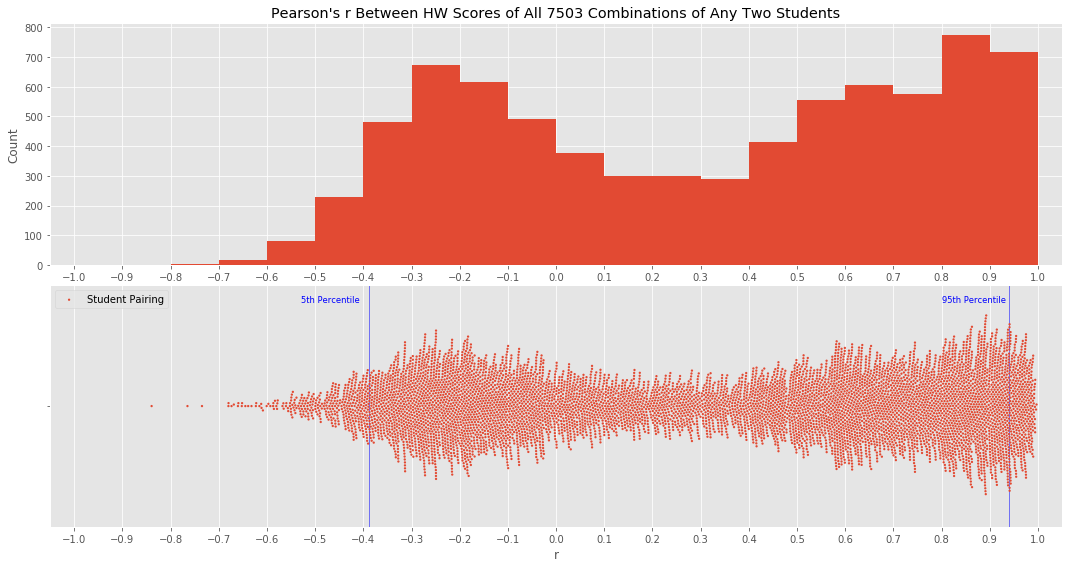

In [14]:
plt.figure(figsize=(15,8))
rrange = [-1.05,1.05]
rticks = np.arange(-1,1.1,.1)

plt.subplot(211)
plt.title("Pearson's r Between HW Scores of All {} Combinations of Any Two Students".format(pairs))
plt.hist(df_hw['r'], bins=rticks)
plt.ylabel('Count')
plt.xlim(rrange)
plt.xticks(rticks)

plt.subplot(212)
plt.xlabel("Pearson's r Between HW Scores of a Student Pairing")
sns.swarmplot(df_hw['r'], size=2.3, label='Student Pairing')
plt.xlim(rrange)
plt.xticks(rticks)
plt.legend()

percentiles = [5,95]
for i, percentile in enumerate(np.percentile(df_hw['r'], percentiles)):
    plt.axvline(percentile, c='b', lw=.5)
    plt.text(percentile-.14, -.43, '{}th Percentile'.format(percentiles[i]), color='b', size='small')

plt.tight_layout(h_pad=0)

In [122]:
rpos

,r,Pairing,HW
3343,0.9970,"(alc643, vlg015)","((0.97, 0.85, 0.94, 0.96, 0.96, 0.9, 0.96, 0.88, 0.81, 0.0), (0.97, 0.87, 0.99, 0.97, 0.97, 0.97..."
4582,0.9960,"(cepdvrrg, h4gldc)","((0.81, 0.88, 0.9, 0.99, 0.94, 0.97, 1.0, 1.0, 0.755, 0.0), (0.83, 0.93, 0.92, 0.99, 0.98, 1.0, ..."
847,0.9943,"(fdr.fkhqcl97, bxc530)","((0.92, 0.79, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0), (0.9, 0.7, 0.99, 1.0, 0.99, 0.98, 1.0, ..."
2955,0.9941,"(da005732, da005756)","((0.0, 0.7, 0.81, 0.97, 0.99, 1.0, 0.98, 0.94, 0.81, 1.0), (0.0, 0.7, 0.81, 0.98, 0.96, 0.91, 0...."
292,0.9937,"(zhc195, h4gldc)","((0.82, 0.91, 0.92, 0.97, 0.96, 0.99, 0.92, 0.9259999999999999, 0.84, 0.0), (0.83, 0.93, 0.92, 0..."
3061,0.9937,"(djhpdzdw, h4gldc)","((0.88, 0.95, 0.95, 0.96, 0.97, 0.99, 1.0, 0.8959999999999999, 0.8, 0.0), (0.83, 0.93, 0.92, 0.9..."


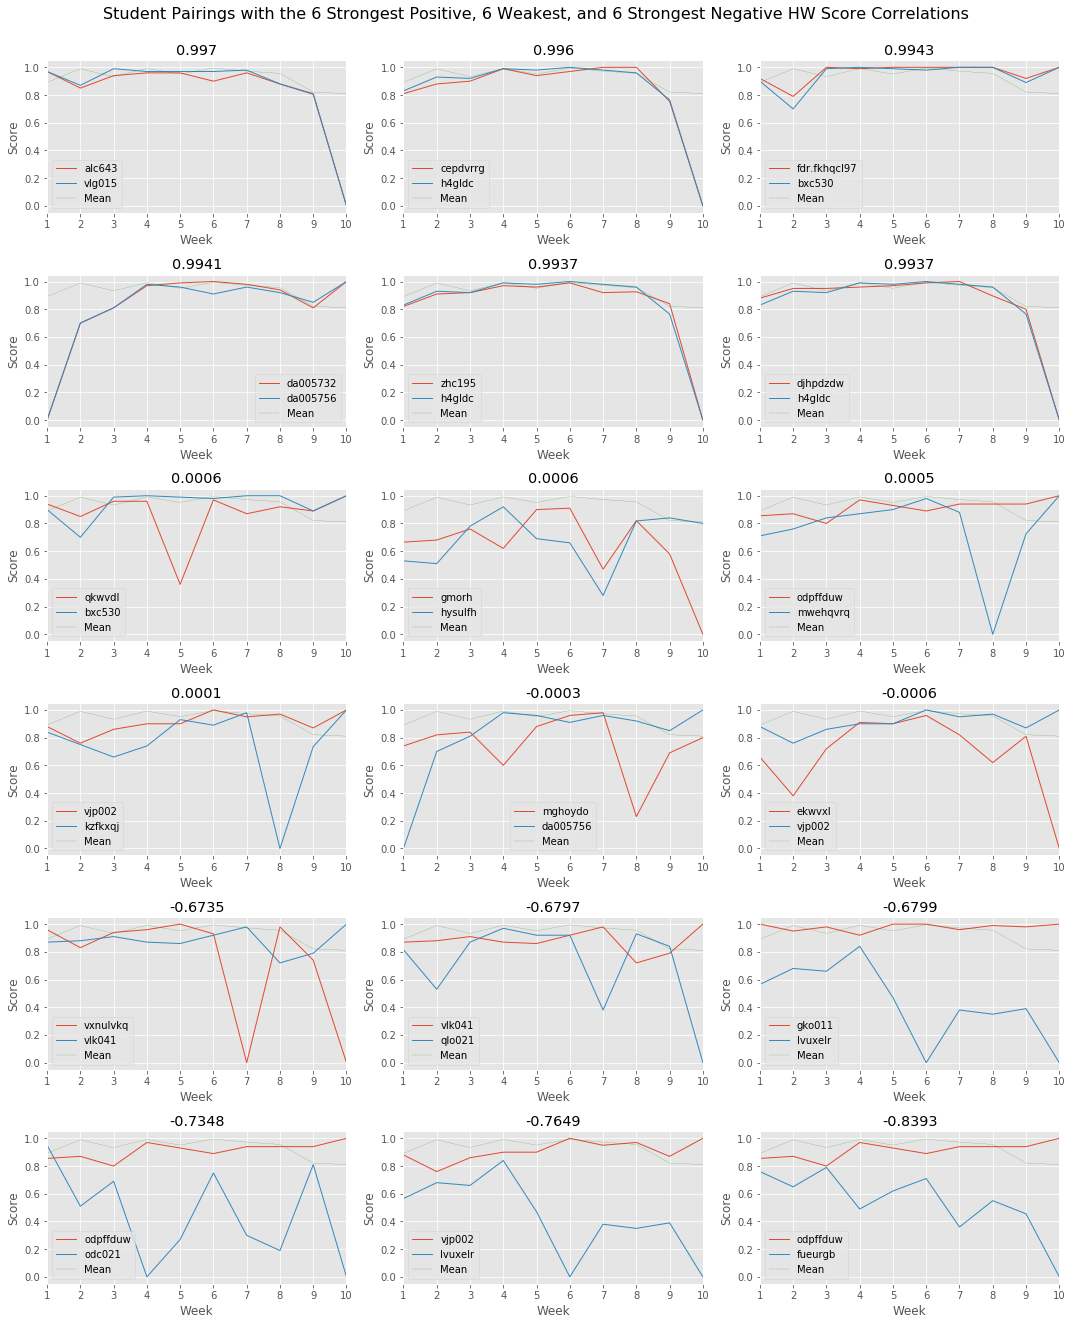

In [167]:
select = 6
rpos  = df_hw[:select]
rneg  = df_hw[-select:]
rzero = df_hw.assign(ab=abs(df_hw['r'])).sort_values('ab').drop('ab',axis=1)[:select].sort_values('r',ascending=False)
rs    = rpos.append(rzero).append(rneg)

plt.figure(figsize=(15, rs.shape[0]))
plt.suptitle('Student Pairings with the 6 Strongest Positive, 6 Weakest, and 6 Strongest Negative HW Score Correlations', size=16, y=1.02)
for pairing in range(rs.shape[0]):
    pair = rs.iloc[pairing]
    plt.subplot(rs.shape[0]/3,3,pairing+1)
    plt.plot(weeks, pair['HW'][0], lw=1, label=pair['Pairing'][0])
    plt.plot(weeks, pair['HW'][1], lw=1, label=pair['Pairing'][1])
    plt.plot(weeks, averages, 'g', lw=.15, label='Mean')
    
    plt.title(round(pair['r'],4))
    plt.xlabel('Week')
    plt.ylabel('Score')
    plt.axis([1,10,-.05,1.05])
    plt.xticks(range(1,11))
    plt.legend()
    
plt.tight_layout()

In [17]:
# hw = df_hw.loc[df_hw.Pairing==(a,b),'HW'].item()
# plt.plot(weeks, hw[0], weeks, hw[1])